| 지표 | 정의 (전체 데이터 기준) |
| --- | --- |
| **Recency** | `현재 step - 마지막 거래 step` |
| **Frequency** | 전체 거래 횟수 |
| **Monetary** | 전체 거래 금액 합계 / 평균 |

[paysim.db] 연결 및 데이터 정합성 맞추기...
Current Step: 806, Period Start: 63
Executing SQL Query...

Data Loaded! Rows: 99999 (Customers)
      nameOrig  last_step  Frequency  MonetarySum  MonetaryAvg  Recency
0  C1000009135         19          0         0.00         0.00      787
1  C1000015836        163          1     77027.49     77027.49      643
2  C1000018718        138          1     32100.16     32100.16      668
3   C100006663         15          0         0.00         0.00      791
4  C1000071455         42          0         0.00         0.00      764

=== RFM Summary Stats ===
     metric  count       mean   median        std        p90
    Recency  99999    558.699   555.00    143.343    770.000
  Frequency  99999      0.980     1.00      0.755      1.000
MonetarySum  99999 181197.273 43871.60 749712.478 367122.166
MonetaryAvg  99999 156433.569 40664.26 553123.178 333609.584


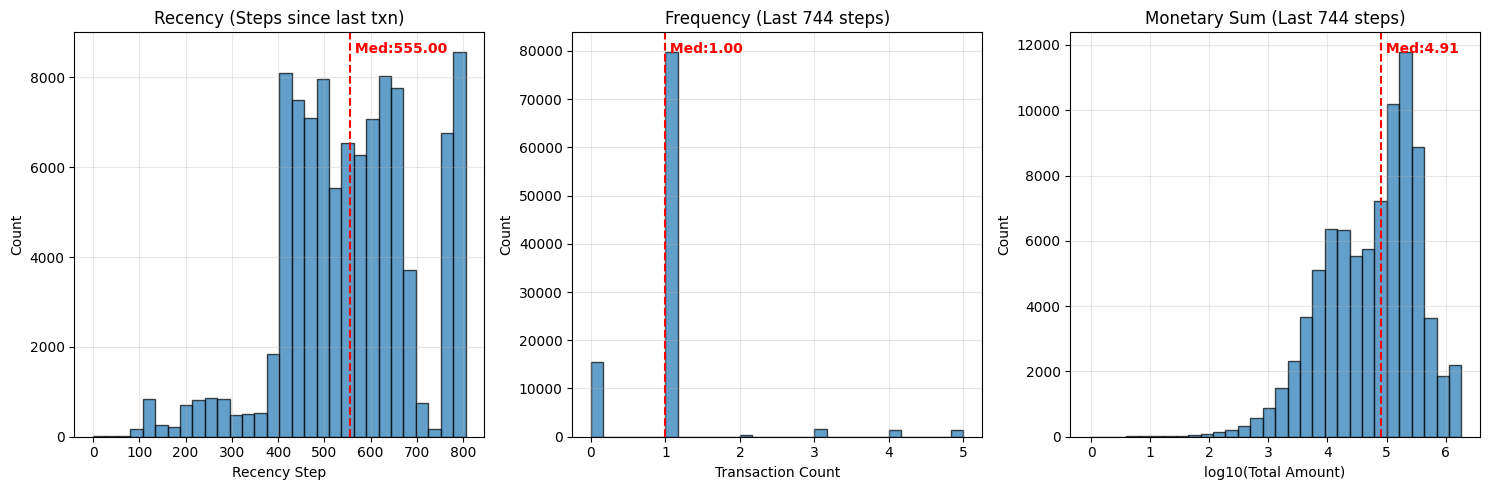


Saved: rfm_sqlite_result.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text

# =========================
# 1) 설정
# =========================
DB_PATH = "paysim.db" 
TABLE   = "PaySim"
period_steps = 744 #과거 데이터 (Step 1 ~ 62)는 제외됨 
clip_pct = 0.99

engine = create_engine(f"sqlite:///{DB_PATH}")

with engine.connect() as conn:
    print(f"[{DB_PATH}] 연결 및 데이터 정합성 맞추기...")

    # [Step 1] 분석 기준 시점(Last Step) 구하기
    # CAST(step AS INTEGER)로 확실하게 정수화
    max_step_query = text(f"SELECT MAX(CAST(step AS INTEGER)) FROM {TABLE}")
    current_step = conn.execute(max_step_query).scalar()
    
    if current_step is None:
        raise ValueError("데이터가 없습니다.")
        
    current_step = int(current_step)
    period_start = current_step - period_steps + 1
    print(f"Current Step: {current_step}, Period Start: {period_start}")

    # [Step 2] RFM 계산 (Python 로직과 100% 일치시키기)
    # Python의 pd.to_numeric(errors='coerce')와 dropna 효과를 내는 쿼리
    print("Executing SQL Query...")
    
    # --파라미터 바인딩(Parameter Binding): :p_start는 이름표임 나중에 실제 변수랑 연결시켜줘야함
    query = text(f"""
        SELECT 
            nameOrig,
            -- 1. Recency용: 조건(CASE WHEN) 없이 전체 기간에서 찾음
            MAX(CAST(step AS INTEGER)) as last_step,
            
            -- Frequency: step을 강제로 정수로 바꾼 뒤 비교
            COUNT(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN 1 END) as Frequency,
            
            -- Monetary: amount를 강제로 실수(Float)로 바꾼 뒤 합산
            -- 데이터가 깨져있으면 0으로 처리되므로 안전함
            COALESCE(SUM(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END), 0) as MonetarySum,
            
            -- MonetaryAvg
            AVG(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END) as MonetaryAvg
        FROM {TABLE}
        WHERE
            -- Python의 dropna()와 같은 역할: 이상한 데이터는 아예 집계에서 뺌
            typeof(step) IN ('integer', 'real') 
            OR (typeof(step) = 'text' AND step GLOB '[0-9]*')
    
        GROUP BY nameOrig
    """)
    
    rfm = pd.read_sql(query, conn, params={"p_start": period_start})

# =========================
# 3) Python 후처리
# =========================
# Recency 계산 (현재 시점 - 마지막 거래 시점)
rfm['Recency'] = current_step - rfm['last_step']

# MonetaryAvg 결측치(거래 없는 경우) 0으로 채우기
rfm['MonetaryAvg'] = rfm['MonetaryAvg'].fillna(0)

print(f"\nData Loaded! Rows: {len(rfm)} (Customers)")
print(rfm.head())

# =========================
# 4) 요약 통계 (Summary Stats)
# =========================
summary = pd.DataFrame({
    'metric': ['Recency','Frequency','MonetarySum','MonetaryAvg'],
    'count':  [rfm['Recency'].notna().sum(),
               rfm['Frequency'].notna().sum(),
               rfm['MonetarySum'].notna().sum(),
               rfm['MonetaryAvg'].notna().sum()],
    'mean':   [rfm['Recency'].mean(),
               rfm['Frequency'].mean(),
               rfm['MonetarySum'].mean(),
               rfm['MonetaryAvg'].mean()],
    'median': [rfm['Recency'].median(),
               rfm['Frequency'].median(),
               rfm['MonetarySum'].median(),
               rfm['MonetaryAvg'].median()],
    'std':    [rfm['Recency'].std(),
               rfm['Frequency'].std(),
               rfm['MonetarySum'].std(),
               rfm['MonetaryAvg'].std()],
    'p90':    [rfm['Recency'].quantile(0.9),
               rfm['Frequency'].quantile(0.9),
               rfm['MonetarySum'].quantile(0.9),
               rfm['MonetaryAvg'].quantile(0.9)]
})
print("\n=== RFM Summary Stats ===")
print(summary.round(3).to_string(index=False))

# =========================
# 5) 시각화 (Visualization)
# =========================
# 시각화 함수 정의
def hist_with_median(ax, data, bins, title, xlabel, clip_at=None, log=False):
    x = data.copy()
    if clip_at is not None:
        cap = x.quantile(clip_at)
        x = x.clip(upper=cap)
    if log:
        # 0 이하 값은 로그 변환 불가하므로 제외
        x = x[x > 0] 
        x = np.log10(x)
        xlabel = f"log10({xlabel})"
    
    x = x.dropna()

    ax.hist(x, bins=bins, edgecolor='black', alpha=0.7)
    
    if len(x) > 0:
        med = x.median()
        ax.axvline(med, color='red', linestyle='--', linewidth=1.5)
        ax.text(med, ax.get_ylim()[1]*0.95, f" Med:{med:.2f}", color='red', fontweight='bold')
        
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)

figsize = (15, 5) # 가로로 긴 형태
fig, axes = plt.subplots(1, 3, figsize=figsize)

# 5-1) Recency
hist_with_median(axes[0],
                 rfm['Recency'],
                 bins=30,
                 title="Recency (Steps since last txn)",
                 xlabel="Recency Step")

# 5-2) Frequency
hist_with_median(axes[1],
                 rfm['Frequency'],
                 bins=30,
                 title=f"Frequency (Last {period_steps} steps)",
                 xlabel="Transaction Count",
                 clip_at=clip_pct)

# 5-3) MonetarySum
hist_with_median(axes[2],
                 rfm['MonetarySum'],
                 bins=30,
                 title=f"Monetary Sum (Last {period_steps} steps)",
                 xlabel="Total Amount",
                 clip_at=clip_pct,
                 log=True)

plt.tight_layout()
plt.show()

# =========================
# 6) 결과 저장
# =========================
# 분석 결과를 CSV로 저장 (필요시)
rfm.to_csv("rfm_sqlite_result.csv", index=False)
print("\nSaved: rfm_sqlite_result.csv")

- paysim데이터 특성 상 극단적인 치우침이 존재하기때문에 평균이 아닌 중위수를 표시함

### 해석

1. Recency Distribution (Full Dataset)
> 대부분의 고객은 약 500~700 step 사이에 마지막 거래를 기록했으며, 거래 시점 기준으로 고객의 최신성을 나타낸 그래프입니다.
> 
> 
> 중앙값(555 step) 기준으로 보았을 때 최근 거래 활동이 활발한 사용자는 비교적 적습니다.
>

2.  Frequency Distribution (Period_step)
> 송신자별 거래 횟수를 나타낸 그래프입니다.
> 
> 
> 대부분의 계정이 단 한 번만 거래를 수행한 것으로 나타나,
> 
> 소수의 반복 거래 계정이 전체 거래 구조를 형성하고 있음을 보여줍니다.
>

3. MonetarySum Distribution (Period_step)
> 송신자별 총 거래 금액(로그 스케일)을 나타낸 그래프입니다.
> 
> 
> 오른쪽으로 갈수록 실제 거래 금액이 커지며,
> 
> 중앙값은 약 10⁴․⁹(약 8만 단위)로 대부분의 사용자는 이 수준의 금액을 거래했습니다.
> 
> 일부 고액 거래 계정으로 인해 분포의 꼬리가 오른쪽으로 길게 늘어납니다.
>



*“오른쪽 꼬리가 길다(right-skewed)”는 값이 큰 일부 관측치들이 평균을 오른쪽으로 끌고 가는 분포”라는 뜻*

*오른쪽 꼬리(long right tail) → 큰 값 쪽으로 길게 늘어난 분포*

*왼쪽 꼬리(long left tail) → 작은 값 쪽으로 길게 늘어난 분포*

---

### RFM 점수를 기반 **고객을 세분화**와 **그룹식별**
코드 목표: 

- RFM 스코어링: 전체 고객을 4등분(Quartile)하여 1~4점 부여. (4점이 최고점)

- 세그먼트 지정: 점수 합계에 따라 등급(VIP, 충성, 잠재, 이탈 등) 부여.

- 시각화: 우리 고객이 어떤 등급에 몰려있는지 한눈에 확인.

- 핵심 타겟 추출: AARRR 분석을 위해 VIP 고객 명단 저장.

In [2]:
# 시각화 스타일 설정
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


=== RFM Scoring & Segmentation ===
Scoring Completed!

[Segment Statistics]
                    Recency  Frequency  MonetarySum  nameOrig
Segment                                                      
Champions (핵심 VIP)    411.8        1.8     602338.1      9521
Loyal (충성 고객)         482.3        1.2     268045.7     29873
Potential (잠재 고객)     546.7        1.0     121888.1     32095
At Risk (이탈 위험)       605.1        1.0      38142.1     11988
Lost (이탈/휴면)          771.1        0.1        491.0     16522


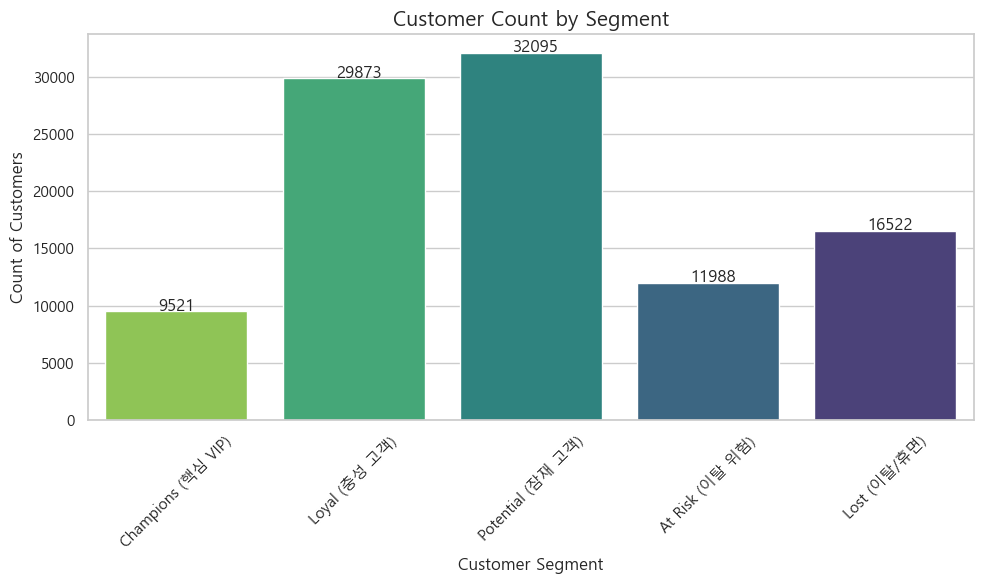

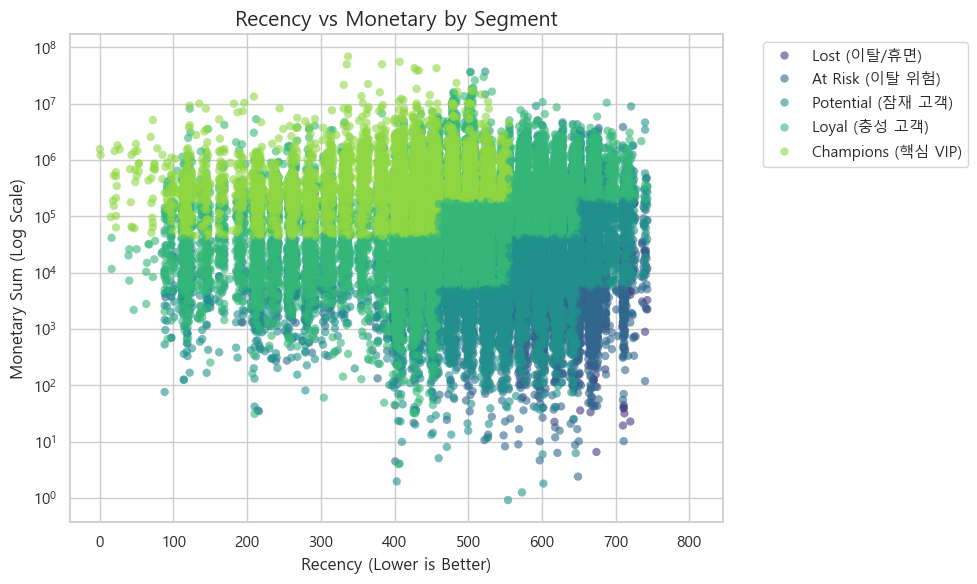


 핵심 활동 고객군(VIP) 추출 완료: 9521명
   - 이들은 전체 고객의 9.5% 입니다.
   - 이들의 평균 거래액: 602,338
 파일 저장 완료: vip_customers_list.csv (엑셀에서 열기 가능)


In [5]:
# =========================
# 1) RFM 스코어링 (1~4점 척도)
# =========================
print("\n=== RFM Scoring & Segmentation ===")

# 동점자 처리(Rank) 후 4등분(qcut)
# method='first': 동점자 발생 시 먼저 나온 데이터에 순위 부여 (오류 방지)

# [Recency] 낮을수록 좋음 (최근 거래) -> 라벨을 [4, 3, 2, 1]로 역순 부여
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4, 3, 2, 1])

# [Frequency] 높을수록 좋음 -> [1, 2, 3, 4]
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# [Monetary] 높을수록 좋음 -> [1, 2, 3, 4]
rfm['M_Score'] = pd.qcut(rfm['MonetarySum'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# RFM 종합 점수 (최대 12점)
# 데이터 타입이 category일 수 있어서 int로 변환 후 합산
rfm['RFM_Total'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

print("Scoring Completed!")

# =========================
# 2) 고객 등급(Segment) 정의
# =========================
# 점수 합계 혹은 R/F 점수 조합으로 등급을 나눕니다.
# 여기서는 이해하기 쉽게 '종합 점수' 기준으로 나눕니다.

def define_segment(score):
    if score >= 11: return 'Champions (핵심 VIP)'    # 11~12점: 최근에, 자주, 많이 씀
    elif score >= 9: return 'Loyal (충성 고객)'      # 9~10점: 우수 고객
    elif score >= 7: return 'Potential (잠재 고객)'  # 7~8점: 성장 가능성 있음
    elif score >= 5: return 'At Risk (이탈 위험)'    # 5~6점: 예전엔 썼으나 지금은 뜸함
    else: return 'Lost (이탈/휴면)'                  # 3~4점: 거의 활동 없음

rfm['Segment'] = rfm['RFM_Total'].apply(define_segment)

# 그룹별 통계 확인
seg_stat = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetarySum': 'mean',
    'nameOrig': 'count'
}).sort_values('MonetarySum', ascending=False) # 금액 높은 순 정렬

print("\n[Segment Statistics]")
print(seg_stat.round(1))

# =========================
# 3) 시각화 (Segmentation Visualization)
# =========================
import seaborn as sns

# 3-1. 등급별 고객 수 (Bar Chart)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Segment', data=rfm, hue='Segment', palette='viridis', order=seg_stat.index)
plt.title("Customer Count by Segment", fontsize=15)
plt.xlabel("Customer Segment")
plt.ylabel("Count of Customers")
plt.xticks(rotation=45)

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+50))
plt.tight_layout()
plt.show()

# 3-2. 산점도 (Scatter Plot): Recency vs Monetary (색상: Segment)
# 우리가 찾는 '핵심 VIP'가 어디에 위치하는지 시각적으로 확인
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm, 
    x='Recency', 
    y='MonetarySum', 
    hue='Segment', 
    palette='viridis',
    alpha=0.6,
    linewidth=0
)
# 로그 스케일 적용 (금액 차이가 크므로)
plt.yscale('log') 
plt.title("Recency vs Monetary by Segment", fontsize=15)
plt.xlabel("Recency (Lower is Better)")
plt.ylabel("Monetary Sum (Log Scale)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2) # 범례 밖으로 뺌
plt.tight_layout()
plt.show()

# =========================
# 4) 다음 분석(AARRR)을 위한 데이터 추출
# =========================
# 'Champions' 그룹만 따로 뽑아서 저장
vip_customers = rfm[rfm['Segment'] == 'Champions (핵심 VIP)']

print(f"\n 핵심 활동 고객군(VIP) 추출 완료: {len(vip_customers)}명")
print(f"   - 이들은 전체 고객의 {len(vip_customers)/len(rfm)*100:.1f}% 입니다.")
print(f"   - 이들의 평균 거래액: {vip_customers['MonetarySum'].mean():,.0f}")

# 윈도우 엑셀에서 한글 안 깨지게 저장 (utf-8-sig 중요!)
vip_customers.to_csv("vip_customers_list.csv", index=False, encoding='utf-8-sig')
print(" 파일 저장 완료: vip_customers_list.csv (엑셀에서 열기 가능)")

- Frequency가 1회인 고객이 아주 많으면, 단순 등분(qcut)할 때 "구간을 나눌 수 없다"는 에러가 날 수 있어서 .rank(method='first')를 써서 동점자(1회 거래자들) 사이에서도 미세하게 순서를 매겨서 강제로 4등분(25%씩)을 만듦

- scatter plot에서 **왼쪽 위**에 몰려있는 점들이 바로 Champions (핵심 VIP) 그룹. AARRR 분석에서 Revenue(수익) 파트를 분석할 때 이 점들이 어떻게 행동했는지 활용

- vip_customers_list.csv가 생성됨. 다음 AARRR 분석에서는 이 리스트를 활용하여 연결






---

### RFM분석에 기반한 사기 거래 탐지 및 분석 확장


===  Fraud Detection & Anomaly Analysis ===
DB에서 사기 거래 이력(isFraud) 조회 중...
✅ 데이터 병합 완료. 총 분석 대상: 99,999명
   - 실제 사기꾼 수: 126.0명

[등급별 사기 발생 현황]
              Segment  Total_Users  Fraud_Users  Fraud_Rate_Pct
1  Champions (핵심 VIP)         9521         42.0            0.44
3       Loyal (충성 고객)        29873         55.0            0.18
4   Potential (잠재 고객)        32095         24.0            0.07
0     At Risk (이탈 위험)        11988          4.0            0.03
2        Lost (이탈/휴면)        16522          1.0            0.01


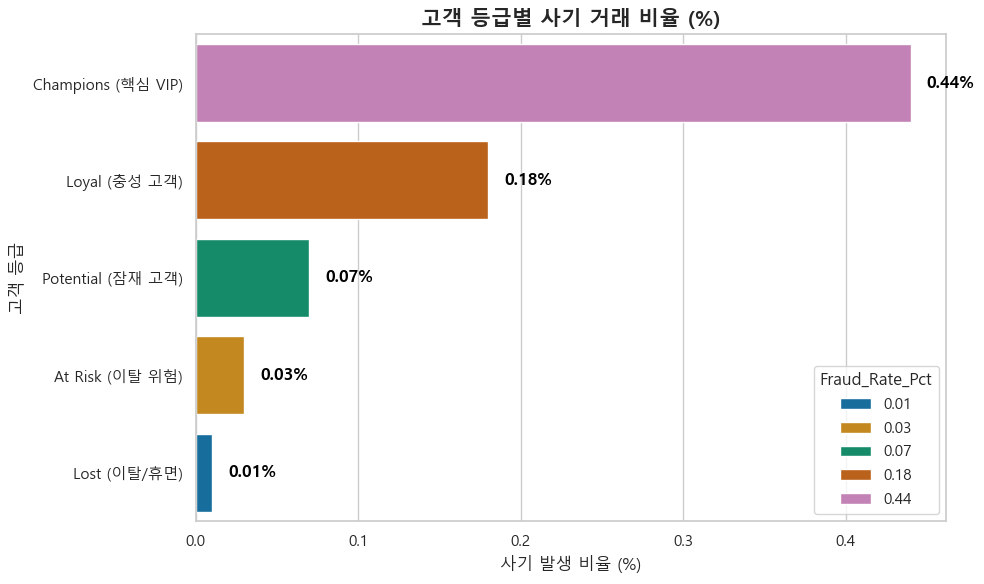


이상치 탐지(Isolation Forest) 모델 가동 중...
모델 분석 완료!
   - 전체 고객 중 통계적 이상치로 분류된 수: 1,000명
   - 그 중 실제 사기(isFraud=1)와 일치한 수: 23명


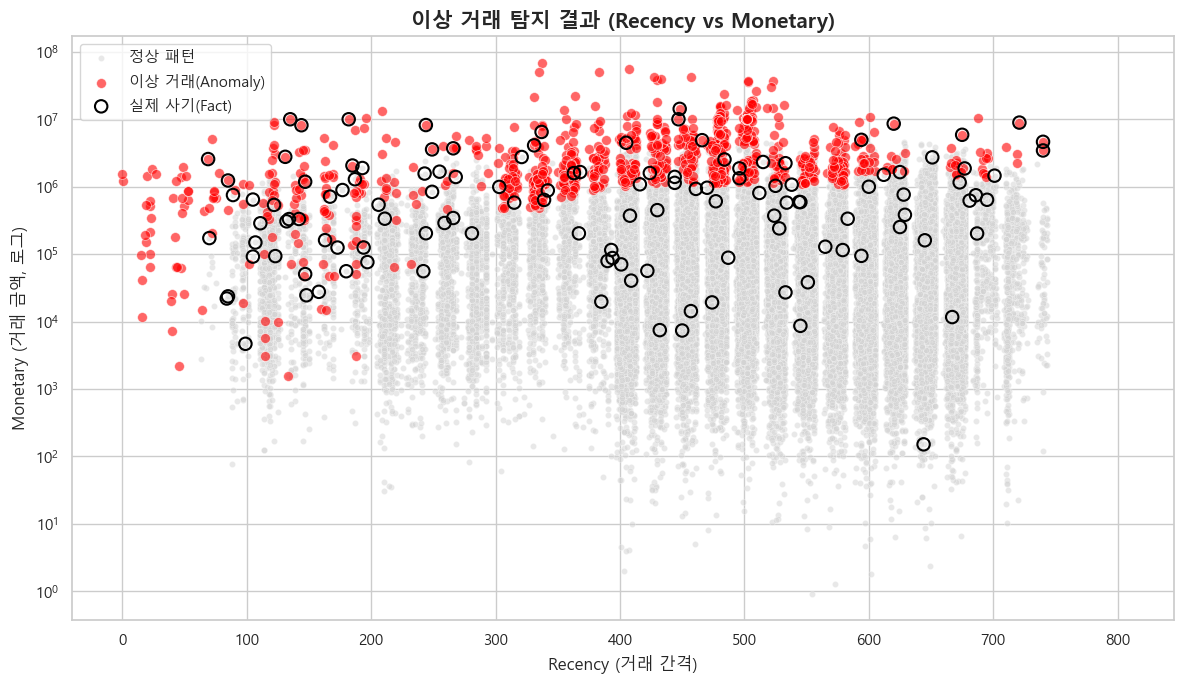


고위험군(High Risk) 명단 추출: 1,103명
파일 저장 완료: high_risk_users.csv


In [8]:
# ==========================================
# [추가 분석] RFM 기반 사기 거래(Fraud) 탐지
# ==========================================
print("\n===  Fraud Detection & Anomaly Analysis ===")

# 1) DB에서 실제 사기 여부(isFraud) 가져오기
# 기존 rfm 데이터프레임에는 isFraud 컬럼이 없으므로 DB에서 다시 조회해서 합쳐야 합니다.
with engine.connect() as conn:
    print("DB에서 사기 거래 이력(isFraud) 조회 중...")
    
    # 분석 기간 내에 사기(isFraud=1) 기록이 한 번이라도 있으면 1로 간주
    fraud_query = text(f"""
        SELECT 
            nameOrig, 
            MAX(CAST(isFraud AS INTEGER)) as isFraud_Actual
        FROM PaySim
        WHERE CAST(step AS INTEGER) >= :p_start
        GROUP BY nameOrig
    """)
    
    fraud_df = pd.read_sql(fraud_query, conn, params={"p_start": period_start})

# 2) 기존 RFM 데이터와 병합 (Merge)
rfm_fraud = rfm.merge(fraud_df, on='nameOrig', how='left')
rfm_fraud['isFraud_Actual'] = rfm_fraud['isFraud_Actual'].fillna(0) # 결측치는 0(정상) 처리

print(f"✅ 데이터 병합 완료. 총 분석 대상: {len(rfm_fraud):,}명")
print(f"   - 실제 사기꾼 수: {rfm_fraud['isFraud_Actual'].sum():,}명")

# ==========================================
# 3) 고객 등급(Segment)별 사기율 분석
# ==========================================
# 어떤 그룹에 사기꾼이 가장 많이 숨어있을까요?
fraud_rate = rfm_fraud.groupby('Segment')['isFraud_Actual'].agg(['count', 'sum', 'mean']).reset_index()
fraud_rate.columns = ['Segment', 'Total_Users', 'Fraud_Users', 'Fraud_Rate']
fraud_rate['Fraud_Rate_Pct'] = (fraud_rate['Fraud_Rate'] * 100).round(2)
fraud_rate = fraud_rate.sort_values('Fraud_Rate', ascending=False)

print("\n[등급별 사기 발생 현황]")
print(fraud_rate[['Segment', 'Total_Users', 'Fraud_Users', 'Fraud_Rate_Pct']])

# ------------------------------------------
# 시각화: 등급별 사기 비율 (Bar Chart)
# ------------------------------------------
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Fraud_Rate_Pct', y='Segment', data=fraud_rate, hue='Fraud_Rate_Pct', palette='colorblind')
plt.title("고객 등급별 사기 거래 비율 (%)", fontsize=15, fontweight='bold')
plt.xlabel("사기 발생 비율 (%)")
plt.ylabel("고객 등급")

# 막대 옆에 수치 표시
for i, v in enumerate(fraud_rate['Fraud_Rate_Pct']):
    ax.text(v + 0.01, i, f"{v}%", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ==========================================
# 4) 비지도 학습 기반 이상치 탐지 (Isolation Forest)
# ==========================================
# 실제 사기 라벨(isFraud)이 없더라도, 통계적으로 "너무 튀는" 놈들을 찾아냅니다.
from sklearn.ensemble import IsolationForest

print("\n이상치 탐지(Isolation Forest) 모델 가동 중...")

# 학습에 사용할 특성 (R, F, M)
features = ['Recency', 'Frequency', 'MonetarySum']
X = rfm_fraud[features]

# 모델 설정 (contamination: 전체 데이터 중 이상치라고 예상하는 비율, 예: 1%)
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
rfm_fraud['Anomaly_Score'] = model.fit_predict(X)

# 결과: -1은 이상치(Anomaly), 1은 정상(Normal)
rfm_fraud['Is_Anomaly'] = rfm_fraud['Anomaly_Score'].apply(lambda x: '이상 거래 의심' if x == -1 else '정상 패턴')

# 이상치로 지목된 사람들 중 실제 사기꾼이 얼마나 포함되었나 확인
anomaly_fraud_count = rfm_fraud[(rfm_fraud['Is_Anomaly'] == '이상 거래 의심') & (rfm_fraud['isFraud_Actual'] == 1)].shape[0]
detected_anomalies = rfm_fraud[rfm_fraud['Is_Anomaly'] == '이상 거래 의심'].shape[0]

print(f"모델 분석 완료!")
print(f"   - 전체 고객 중 통계적 이상치로 분류된 수: {detected_anomalies:,}명")
print(f"   - 그 중 실제 사기(isFraud=1)와 일치한 수: {anomaly_fraud_count:,}명")

# ------------------------------------------
# 시각화: 이상치 탐지 결과 산점도 
# ------------------------------------------
plt.figure(figsize=(12, 7))

# 정상 패턴 (회색, 작게)
sns.scatterplot(
    data=rfm_fraud[rfm_fraud['Is_Anomaly'] == '정상 패턴'],
    x='Recency', y='MonetarySum',
    color='lightgray', alpha=0.5, s=20, label='정상 패턴'
)

# 이상 거래 의심 (빨간색, 크게)
sns.scatterplot(
    data=rfm_fraud[rfm_fraud['Is_Anomaly'] == '이상 거래 의심'],
    x='Recency', y='MonetarySum',
    color='red', alpha=0.6, s=50, label='이상 거래(Anomaly)'
)

# 실제 사기 (검은 테두리) - 모델이 못 찾았더라도 표시
fraud_only = rfm_fraud[rfm_fraud['isFraud_Actual'] == 1]
plt.scatter(
    fraud_only['Recency'], fraud_only['MonetarySum'],
    facecolors='none', edgecolors='black', s=80, linewidth=1.5, label='실제 사기(Fact)'
)

plt.yscale('log')
plt.title("이상 거래 탐지 결과 (Recency vs Monetary)", fontsize=15, fontweight='bold')
plt.xlabel("Recency (거래 간격)")
plt.ylabel("Monetary (거래 금액, 로그)")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# 5) 고위험군 리스트 추출 (Action Item)
# ==========================================
# 1순위: 모델이 이상하다고 했으면서 + 실제 사기 이력이 있거나 + VIP 등급인 경우
high_risk_users = rfm_fraud[
    (rfm_fraud['Is_Anomaly'] == '이상 거래 의심') | 
    (rfm_fraud['isFraud_Actual'] == 1)
].sort_values('MonetarySum', ascending=False)

print(f"\n고위험군(High Risk) 명단 추출: {len(high_risk_users):,}명")
high_risk_users.to_csv("high_risk_users.csv", index=False, encoding='utf-8-sig')
print("파일 저장 완료: high_risk_users.csv")

### 분석결과
1.  발생한 사기 건수: 171건 / 사기계정의 수: 126명 -> 차이가 남, 재범발생


In [9]:
# ==========================================
# 상습범(Repeat Offenders) 추적
# ==========================================

# 1) 원본 데이터에서 사기 건수 조회
# (우리가 만든 rfm 변수는 이미 user별로 묶여 있어서, 원본을 봐야 함)

with engine.connect() as conn:
    query = text(f"""
        SELECT 
            nameOrig, 
            COUNT(*) as fraud_count,            -- 사기 친 횟수
            SUM(amount) as total_fraud_amount   -- 총 사기 금액
        FROM {TABLE}
        WHERE isFraud = 1                       -- 사기 거래만 필터링
        AND step >= :p_start                    -- 우리가 정한 분석 기간 내
        GROUP BY nameOrig
        HAVING fraud_count > 1                  -- 1번 넘게 친 놈만 조회
        ORDER BY fraud_count DESC
    """)
    
    repeat_offenders = pd.read_sql(query, conn, params={"p_start": period_start})

print(f"\n상습 사기꾼(2회 이상) 명단: {len(repeat_offenders)}명")
print(repeat_offenders.head(10)) # 상위 10명 출력

# 2) 사기 횟수별 분포 확인
if not repeat_offenders.empty:
    print(f"\n- 최대 많이 친 횟수: {repeat_offenders['fraud_count'].max()}회")
    print(f"- 상습범들이 챙긴 총 금액: {repeat_offenders['total_fraud_amount'].sum():,.0f}원")


상습 사기꾼(2회 이상) 명단: 10명
      nameOrig  fraud_count  total_fraud_amount
0  C2136238029            5        1.236131e+06
1  C1011665365            5        6.079299e+05
2   C743231238            4        2.893110e+05
3   C684914427            4        1.184492e+06
4  C1093983453            4        4.103705e+06
5   C992917413            3        5.882217e+06
6   C378910639            3        6.400292e+05
7  C1998644906            3        1.425935e+07
8  C1131884196            3        8.153284e+06
9  C1034067842            3        2.568678e+06

- 최대 많이 친 횟수: 5회
- 상습범들이 챙긴 총 금액: 38,925,131원


- 5번친 계정 벌견 -> 자동화된 봇 의심 / 보안시스템의 허점을 뚫음 

2. 고객 등급별 사기 거래 비율 (Bar Chart)

Champions(핵심 VIP)의 사기율이 0.44%로 압도적 1위:

일반적인 상식("VIP는 충성 고객이니 안전하다")을 뒤집는 결과가 나옴.

해석: 사기꾼들이 **계정을 탈취(Account Takeover)**해서 VIP인 척 거액을 송금했거나, 아니면 처음부터 신용을 쌓은 뒤 크게 한탕(Long Con) 치고 빠졌을 가능성이 큼.

액션 아이템: "Champions 등급의 고액 송금은 보안 절차(OTP 등)를 한 단계 더 강화해야 한다"는 전략을 제안할 수 있음.

3. 이상 거래 탐지 결과 (Scatter Plot)

빨간 점(모델이 찾은 이상치): 주로 그래프 **위쪽(고액 거래)**에 몰려 있음. 비지도모델은 고액이면 이상치라고 분류했음을 알 수 있음

검은 동그라미(실제 사기): 그래프 전체에 골고루 퍼져 있음. 심지어 아래쪽(소액 거래)이나 회색 영역(정상 패턴) 한가운데 숨어 있는 사기꾼도 많음.

결론: "금액(Monetary)" 하나만으로는 모든 사기꾼을 잡을 수 없다는 증거

>100명 중 23명 사기꾼 
>
>-> 나머지 977명은 이상치로 분류될정도로 거래량이 많고, 거래빈도가 높은 >찐VIP임, 이들은 특별관리대상(superVIP)로 분류하면 좋음
>
>-> 놓친 103명의 사기꾼들은 이상치에 안걸리게 거래한 지능범임


---

### **산출물**

핵심 타겟 확보: 우리 매출을 책임지는 VIP 명단 (vip_customers_list.csv)

리스크 관리: 사기 위험이 높은 블랙리스트 (high_risk_users.csv)

인사이트: VIP 등급에서 오히려 사기 비율이 높다는 충격적인 사실 발견

---

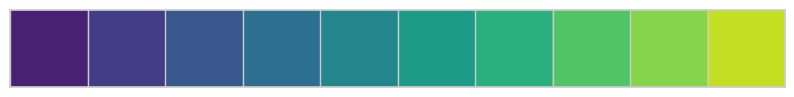

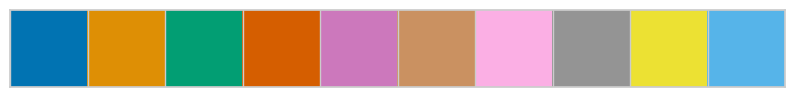

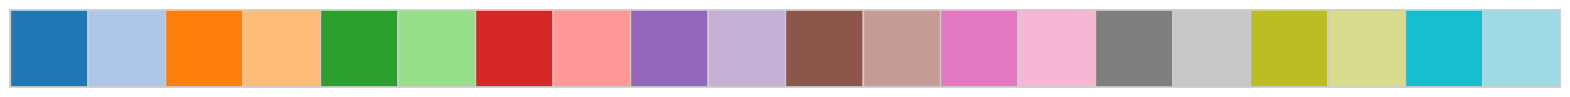

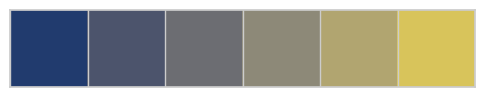

In [13]:
sns.palplot(sns.color_palette("viridis", 10))
sns.palplot(sns.color_palette("colorblind"))
sns.palplot(sns.color_palette("tab20"))
sns.palplot(sns.color_palette("cividis"))